# Classification of Apoptotic cells

In this jupyter notebook, we provide an example of how to extract explainable features and run a classification for the imaging flow cytometry dataset provided by:

In vivo identification of apoptotic and extracellular vesicle-bound live cells using image-based deep learning https://doi.org/10.1080%2F20013078.2020.1792683


We assume you have already installed the library. Otherwise you can install it using 

`!pip -q install <Path to the cloned module>`

This notebook provides an example for deep learning methods

here we import a series of needed modules. 

In [1]:
import scifAI
import numpy as np
from sklearn.datasets import make_classification
import torch.nn as nn
from skorch import NeuralNetClassifier
import matplotlib.pyplot as plt
import glob
from imageio import imread
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import torch
from torchvision import transforms
from IPython.core.debugger import Tracer
from torch.utils.data import DataLoader, Dataset
from sklearn.pipeline import Pipeline, FeatureUnion
# Compare Algorithms
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score

In [2]:
from scifAI.dl.utils import calculate_weights, get_statistics
from scifAI.dl.dataset import DatasetGenerator
from scifAI.dl.custom_transforms import ShuffleChannel
from scifAI.dl.models import PretrainedModel, resnet18

In [3]:
from iflai.dl.models import PretrainedModel
from skorch.callbacks import LRScheduler,Checkpoint,EpochScoring,EarlyStopping
import torch.optim as optim
from skorch.helper import predefined_split

here, we provide a function for visualizing the result of the confusion matrix which will be used later.

In [4]:
from sklearn.metrics import (plot_confusion_matrix, 
                             matthews_corrcoef, 
                             classification_report,
                             confusion_matrix, 
                             accuracy_score, 
                             balanced_accuracy_score, 
                             cohen_kappa_score, 
                             f1_score,  
                             precision_score, recall_score)
from imblearn.metrics import classification_report_imbalanced

def classification_complete_report(y_true, y_pred, plot = True ): 
    print(classification_report(y_true, y_pred))
    print(15*"----")
    print("matthews correlation coeff: %.2f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.2f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.2f & balanced Accuracy: %.2f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.2f & micro F1 score: %.2f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.2f & micro Precision score: %.2f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.2f & micro Recall score: %.2f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    

now lets calculate the metadata:

In [5]:
%%time

data_path = "/pstore/data/DS4/Apoptotic_cell_detection/"
metadata = scifAI.metadata_generator(data_path)

Metadata prepration starts...
Experiment_1 Donor_1 condition_1


100%|██████████| 15311/15311 [00:02<00:00, 5508.31it/s]


...metadata prepration ended.
CPU times: user 229 ms, sys: 173 ms, total: 402 ms
Wall time: 3.24 s


In [6]:
metadata

,file,experiment,donor,condition,object_number,set,label
0,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,822,labeled,apoptotic
1,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,12187,labeled,non-apoptotic
2,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,2295,labeled,apoptotic
3,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,14306,labeled,non-apoptotic
4,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,2584,labeled,apoptotic
...,...,...,...,...,...,...,...
15306,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,10365,labeled,apoptotic
15307,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,2952,labeled,apoptotic
15308,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,7308,labeled,non-apoptotic
15309,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,3211,labeled,apoptotic


['apoptotic' 'non-apoptotic']


<AxesSubplot:>

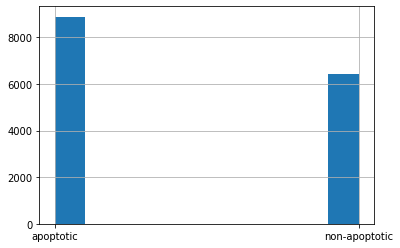

In [7]:
print(metadata.label.unique())
metadata.label.hist()

so we have 31280  files with various labels. first we need to get rid of `unknown` labels

In [8]:
row_index = metadata.label != "unknown"

metadata = metadata.loc[row_index,:].reset_index(drop = True)

lets plot a random image per class

apoptotic
non-apoptotic


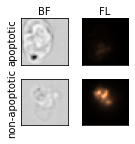

In [9]:
from skimage.util import crop
import h5py

def crop_pad_h_w(image_dummy,reshape_size):
    if image_dummy.shape[0] < reshape_size:
        h1_pad = ( reshape_size - image_dummy.shape[0])/2
        h1_pad = int(h1_pad)
        h2_pad =  reshape_size - h1_pad - image_dummy.shape[0]
        h1_crop = 0
        h2_crop = 0
    else:
        h1_pad = 0
        h2_pad = 0
        h1_crop = ( reshape_size - image_dummy.shape[0])/2
        h1_crop = abs(int(h1_crop))
        h2_crop = image_dummy.shape[0]- reshape_size  - h1_crop

    if image_dummy.shape[1] < reshape_size:
        w1_pad = (reshape_size - image_dummy.shape[1])/2
        w1_pad = int(w1_pad)
        w2_pad = reshape_size - w1_pad - image_dummy.shape[1]
        w1_crop = 0
        w2_crop = 0
    else:
        w1_pad = 0
        w2_pad = 0
        w1_crop = (reshape_size - image_dummy.shape[1])/2
        w1_crop = abs(int(w1_crop))
        w2_crop = image_dummy.shape[1]- reshape_size  - w1_crop

    h = [h1_crop, h2_crop, h1_pad, h2_pad]
    w = [w1_crop, w2_crop, w1_pad, w2_pad] 
    return h, w

def plot_images_with_metadata(metadata,  
                              figsize = None,
                              channels = ["BF","BF", "BF"],
                    channel_colors =  ["Greys", "Oranges", "Blues"],
                    image_size = 128):
    
    metadata_dummy = metadata.copy()
    metadata_dummy = metadata_dummy.reset_index(drop = True)
    
    nrows = len(metadata_dummy)
    ncols = len(channel_colors)
    
    if figsize is None:
        figsize = ( ncols*2, nrows*2 )
    fix,ax = plt.subplots(nrows, ncols, figsize = figsize, tight_layout = True)
    
    vmin = [4095.]*ncols
    vmax = [0.]*ncols
    
    for i in range(nrows):
        h5_file_ = h5py.File(metadata_dummy.loc[i,"file"], "r")
        image = h5_file_.get("image")[()]
        for j, ch in enumerate(range(ncols)):
            vmin[j] = min(vmin[j], image[:,:,ch].min()  )
            vmax[j] = max(vmax[j], image[:,:,ch].max()  )
        
    for i in range(nrows):
        h5_file_ = h5py.File(metadata_dummy.loc[i,"file"], "r")
        image = h5_file_.get("image")[()]         
        
        h, w = crop_pad_h_w(image, image_size)
        h1_crop, h2_crop, h1_pad, h2_pad =  h 
        w1_crop, w2_crop, w1_pad, w2_pad = w 
        for j, ch in enumerate(channel_colors):
            image_dummy = crop(image[:,:,j], ((h1_crop,h2_crop),(w1_crop,w2_crop)))            
            image_dummy = np.pad(image_dummy, 
                                     ((h1_pad,h2_pad),(w1_pad,w2_pad)), 
                                     'constant', 
                                     constant_values = np.mean(image_dummy) )
            ax[i,j].imshow(image_dummy, cmap = channel_colors[j] , vmin = vmin[j], vmax = vmax[j]  )
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            
            if j == 0:
                print(metadata_dummy.loc[i,"label"])
                ax[i,j].set_ylabel(metadata_dummy.loc[i,"label"])
            if i == 0:
                ax[i,j].set_xlabel(channels[j])
                ax[i,j].xaxis.set_label_position('top') 
            
        h5_file_.close()
    plt.tight_layout()

    
plot_images_with_metadata(metadata.groupby('label').apply(lambda s: s.sample(1, random_state = 2)).reset_index(drop = True) ,  
                              figsize = (2,2),
                    channel_colors =  ["Greys", "copper"],
                          channels = ["BF","FL"],
                    image_size = 32)



plt.savefig("Dataset 1 - apoptotic vs non apoptotic cells.png", bbox_inches='tight')
plt.savefig("Dataset 1 - apoptotic vs non apoptotic cells.svg", bbox_inches='tight')

Set all random seeds to the specific value, so the results are more reproducable

In [10]:
seed_value = 42

os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)

np.random.seed(seed_value)
torch.manual_seed(seed_value)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Define all necessary parameters

In [11]:

model_dir = "models"
log_dir = "logs"
scaling_factor = 255.
reshape_size = 32


In [12]:
batch_size = 128
num_workers = 4
device="cuda"

In [13]:
channel_importance = pd.read_csv("channel_importance.csv")

In [14]:
from sklearn.preprocessing import MinMaxScaler
interpretation_methods = ["PXPermute", "DeepLift", "IntegratedGradients", "LRP", "GuidedGradCAM"]
channel_importance.loc[:, interpretation_methods] = MinMaxScaler().fit_transform(channel_importance.loc[:, interpretation_methods])

channel_importance

,fold,channel,PXPermute,DeepLift,IntegratedGradients,LRP,GuidedGradCAM
0,1,Ch0,0.016934,0.536150,0.965327,0.089264,0.147628
1,1,Ch1,0.967601,0.230190,0.059443,0.429087,0.147888
2,3,Ch0,0.000000,0.299684,0.475304,0.000000,0.158674
3,3,Ch1,0.918331,0.183626,0.135990,0.268165,1.000000
4,4,Ch0,0.015669,0.559447,0.734979,0.404710,0.221419
5,4,Ch1,0.993797,0.183922,0.203820,0.322268,0.988272
6,2,Ch0,0.021791,0.602487,0.659754,0.228663,0.152042
7,2,Ch1,0.952428,0.187828,0.169965,0.399413,0.068092
8,5,Ch0,0.006567,1.000000,1.000000,1.000000,0.159642
9,5,Ch1,1.000000,0.000000,0.000000,0.206133,0.000000


<AxesSubplot:xlabel='variable', ylabel='value'>

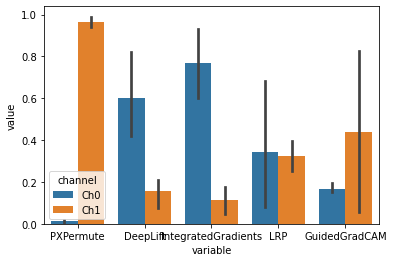

In [15]:
import seaborn as sns
sns.barplot(data = pd.melt(channel_importance, id_vars=["fold","channel"]), 
            x = "variable", 
            y = "value",
            hue = "channel")

In [16]:
def select_top_channels(channel_importance, method, num_top_channels):
    grouped_importance = channel_importance.loc[:,["channel",method]].groupby("channel").mean()
    grouped_importance = grouped_importance.sort_values(by=method, ascending = False) 
    selected_channels = grouped_importance.index[:num_top_channels]
    selected_channels = [int(ch.replace("Ch","")) for ch in selected_channels]
    return selected_channels

In [17]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    
class MinMaxScaler(object):
    def __init__(self, min_in , max_in, min_out, max_out):
        self.min_in = min_in.reshape(-1,1,1)
        self.max_in = max_in.reshape(-1,1,1)
        self.min_out = min_out
        self.max_out = max_out
        
    def __call__(self, tensor):
        
        tensor_ = (tensor - self.min_in)/(self.max_in - self.min_in)
        tensor_ = tensor_*(self.max_out - self.min_out) + self.min_out
        tensor_[tensor_<self.min_out]= self.min_out
        tensor_[tensor_>self.max_out]= self.max_out
        return tensor_
    
    def __repr__(self):
        return self.__class__.__name__ + '(min_out={0}, max_out={1})'.format(self.min_out, self.max_out)

In [18]:

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import torch.nn as nn
from scifAI.dl.models import PretrainedModel
import torch.nn.functional as F

num_top_channels = 1
skf = StratifiedKFold(n_splits=5, random_state=seed_value, shuffle=True)


results_with_best_channels = pd.DataFrame(columns = ["method",
                                                     "f1_micro",
                                                     "f1_macro",
                                                     "accuracy"])

for met in interpretation_methods:
    selected_channels = select_top_channels(channel_importance, met , num_top_channels)
    channels = np.asarray([ "Ch" + str(i) for i in selected_channels])
    
    print(met, selected_channels)
    num_of_all_channels = len(channels)
    all_channels = np.arange(num_of_all_channels)
    for train_index, test_index in skf.split(metadata.index.tolist(), metadata["label"]):
        train_index, validation_index, _, _ = train_test_split(train_index, 
                                                    metadata.loc[train_index,"label"].index.tolist(), 
                                                    stratify = metadata.loc[train_index,"label"].tolist(),
                                                    test_size=0.2, 
                                                    random_state=seed_value)
        label_map = dict(zip(sorted(set(metadata.loc[train_index, "label"])), 
                     np.arange(len(set(metadata.loc[train_index, "label"])))))

        set_of_interesting_classes = metadata.label.unique().tolist()

        num_classes = len(metadata.label.unique())
        
        train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor,
                                 reshape_size=reshape_size,
                                 transform=transforms.Compose([ ] ))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        statistics = get_statistics(train_loader, selected_channels=selected_channels)
        
        stats = dict()
        stats["lower_bound"] = torch.tensor([statistics['p01'][0]])
        stats["upper_bound"] = torch.tensor([statistics['p99'][0]])

        train_transform = [ 
                MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                        max_in =  stats["upper_bound"] , 
                                        min_out =  0. , 
                                        max_out =  1.),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                AddGaussianNoise(mean=0., std=0.01),
        ]

        validation_transform =  [ 
                MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                        max_in =  stats["upper_bound"] , 
                                        min_out =  0. , 
                                        max_out =  1.),
        ]

        test_transform =  [ 
                MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                        max_in =  stats["upper_bound"] , 
                                        min_out =  0. , 
                                        max_out =  1.),
        ]
        train_loader = None
        
        train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor, 
                                 reshape_size=reshape_size,
                                 transform= transforms.Compose(train_transform))

        validation_dataset = DatasetGenerator(metadata=metadata.loc[validation_index,:],
                                              label_map=label_map,
                                              selected_channels=selected_channels,
                                              scaling_factor=scaling_factor,
                                              reshape_size=reshape_size,
                                              transform=transforms.Compose(validation_transform))
        
        test_dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                        label_map=label_map,
                                        selected_channels=selected_channels,
                                        scaling_factor=scaling_factor,
                                        reshape_size=reshape_size,
                                        transform=
                                        transforms.Compose(test_transform))
        
        

        resnet18_modified = PretrainedModel(num_channels = len(selected_channels),
                                             num_classes = len(set_of_interesting_classes), 
                                             pretrained = True)
        
        lr_scheduler = LRScheduler(policy='ReduceLROnPlateau', factor=0.5, patience=5)

        epoch_scoring_f1_micro = EpochScoring("f1_micro", 
                                     name =  "valid_f1_micro", 
                                     on_train = False,
                                     lower_is_better = False)

        epoch_scoring_f1_macro = EpochScoring("f1_macro", 
                                     name =  "valid_f1_macro", 
                                     on_train = False,
                                     lower_is_better = False)

        early_stopping = EarlyStopping(monitor='valid_f1_macro', 
                                       patience=50, 
                                       threshold=0.0001, 
                                       threshold_mode='rel', 
                                       lower_is_better=False)

        checkpoint = Checkpoint(f_params='apoptotic_cells_DL_method_comparison.pth',
                                monitor='valid_f1_macro_best', load_best=True)
        
        net = NeuralNetClassifier(    
            resnet18_modified, 
            criterion=nn.CrossEntropyLoss,
            lr=0.001,
            batch_size=batch_size,
            max_epochs=1000,
            optimizer=optim.Adam,
            iterator_train__shuffle=True,
            iterator_train__num_workers=num_workers,
            iterator_valid__shuffle=False,
            iterator_valid__num_workers=2,
            callbacks=[lr_scheduler, epoch_scoring_f1_micro, 
                       epoch_scoring_f1_macro, 
                       early_stopping, checkpoint],
            train_split=predefined_split(validation_dataset),
            device="cuda",
            warm_start=True)
        net = net.fit(train_dataset, y = None)
        net.module.load_state_dict(torch.load('apoptotic_cells_DL_method_comparison.pth')) 
        
        inv_label_map = {v: k for k, v in label_map.items()}

        preds = net.predict(test_dataset)
        preds =  [inv_label_map[int(t)] for t in preds]
        
        results_with_best_channels = results_with_best_channels.append({
            "method":met,
            "f1_micro":f1_score(test_dataset.metadata.label, preds, average="micro"),
            "f1_macro":f1_score(test_dataset.metadata.label, preds, average="macro"),
            "accuracy":accuracy_score(test_dataset.metadata.label, preds),
        },ignore_index = True)
        net = None
        resnet18_modified = None
        torch.cuda.empty_cache()
        print("---------------------------"*3)

PXPermute


100%|██████████| 77/77 [00:08<00:00,  8.61it/s]


statistics used: {'min': tensor([0.]), 'p01': tensor([0.0170]), 'p05': tensor([0.0272]), 'p25': tensor([0.0483]), 'p50': tensor([0.0758]), 'p75': tensor([0.1620]), 'p95': tensor([0.7778]), 'p99': tensor([2.1694]), 'max': tensor([247.5107]), 'mean': tensor([0.2220]), 'std': tensor([1.9308])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.3011       0.8935            0.8927            0.8935        0.2633     +  5.5429
      2        0.2146       0.8861            0.8840            0.8861        0.2801        5.5650
      3        0.1968       0.9073            0.9059            0.9073        0.2108     +  5.4779
      4        0.1886       0.9282            0.9271            0.9282        0.1757     +  5.4922
      5        0.1798       0.8808            0.8805            0.8808        0.3075        5.5418
      6        

     72        0.0534       0.9376            0.9361            0.9376        0.1757        5.5307
     73        0.0467       0.9424            0.9406            0.9424        0.1789        5.5403
     74        0.0521       0.9420            0.9405            0.9420        0.1656        5.6084
     75        0.0523       0.9376            0.9361            0.9376        0.1689        5.6459
     76        0.0422       0.9367            0.9353            0.9367        0.1953        5.5449
     77        0.0457       0.9392            0.9373            0.9392        0.1937        5.6858
     78        0.0456       0.9331            0.9320            0.9331        0.2305        5.5221
Stopping since valid_f1_macro has not improved in the last 50 epochs.
---------------------------------------------------------------------------------


100%|██████████| 77/77 [00:08<00:00,  8.75it/s]


statistics used: {'min': tensor([0.]), 'p01': tensor([0.0169]), 'p05': tensor([0.0272]), 'p25': tensor([0.0480]), 'p50': tensor([0.0762]), 'p75': tensor([0.1629]), 'p95': tensor([0.7811]), 'p99': tensor([2.1453]), 'max': tensor([250.7375]), 'mean': tensor([0.2232]), 'std': tensor([2.0162])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.3065       0.9012            0.8960            0.9012        0.2291     +  5.5345
      2        0.2106       0.9208            0.9195            0.9208        0.2130     +  5.5142
      3        0.1934       0.9037            0.9028            0.9037        0.2424        5.4894
      4        0.1809       0.9261            0.9252            0.9261        0.2271     +  5.4924
      5        0.1726       0.9171            0.9159            0.9171        0.2120        5.5473
      6        

     73        0.0341       0.9453            0.9439            0.9453        0.2176        5.4987
     74        0.0396       0.9384            0.9370            0.9384        0.2311        5.4629
     75        0.0311       0.9359            0.9345            0.9359        0.2704        5.5512
     76        0.0317       0.9461            0.9449            0.9461        0.2161        5.5787
     77        0.0324       0.9363            0.9351            0.9363        0.2635        5.5541
     78        0.0332       0.9416            0.9403            0.9416        0.2033        5.5894
     79        0.0310       0.9396            0.9382            0.9396        0.2578        5.5078
     80        0.0292       0.9412            0.9399            0.9412        0.2486        5.5227
     81        0.0339       0.9429            0.9413            0.9429        0.2209        5.5197
     82        0.0326       0.9429            0.9411            0.9429        0.2133        5.4665
     83   

100%|██████████| 77/77 [00:08<00:00,  8.66it/s]


statistics used: {'min': tensor([0.]), 'p01': tensor([0.0172]), 'p05': tensor([0.0271]), 'p25': tensor([0.0482]), 'p50': tensor([0.0761]), 'p75': tensor([0.1647]), 'p95': tensor([0.7964]), 'p99': tensor([2.2115]), 'max': tensor([247.5681]), 'mean': tensor([0.2254]), 'std': tensor([1.9382])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.3125       0.7339            0.7322            0.7339        0.6793     +  5.4852
      2        0.2132       0.8845            0.8834            0.8845        0.2739     +  5.5277
      3        0.1972       0.8555            0.8553            0.8555        0.3879        5.5983
      4        0.1812       0.7980            0.7980            0.7980        0.5946        5.5241
      5        0.1748       0.8747            0.8743            0.8747        0.2705        5.5849
      6        

     71        0.0445       0.9469            0.9455            0.9469        0.1846        5.4878
     72        0.0494       0.9449            0.9434            0.9449        0.1891        5.5861
     73        0.0547       0.9388            0.9376            0.9388        0.1863        5.5399
     74        0.0478       0.9404            0.9390            0.9404        0.2201        5.5704
     75        0.0424       0.9388            0.9373            0.9388        0.2109        5.5349
     76        0.0465       0.9457            0.9444            0.9457        0.1602        5.4881
     77        0.0440       0.9351            0.9337            0.9351        0.2069        5.5624
     78        0.0426       0.9449            0.9435            0.9449        0.1877        5.5172
     79        0.0374       0.9437            0.9423            0.9437        0.1799        5.4958
     80        0.0390       0.9461            0.9444            0.9461        0.2367        5.5029
     81   

100%|██████████| 77/77 [00:09<00:00,  8.52it/s]


statistics used: {'min': tensor([0.]), 'p01': tensor([0.0172]), 'p05': tensor([0.0272]), 'p25': tensor([0.0482]), 'p50': tensor([0.0761]), 'p75': tensor([0.1634]), 'p95': tensor([0.7914]), 'p99': tensor([2.1942]), 'max': tensor([250.7378]), 'mean': tensor([0.2242]), 'std': tensor([1.9192])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.2893       0.9086            0.9062            0.9086        0.2285     +  5.5031
      2        0.2048       0.8494            0.8488            0.8494        0.3624        5.4910
      3        0.1953       0.8878            0.8870            0.8878        0.2868        5.5750
      4        0.1716       0.8559            0.8558            0.8559        0.3825        5.4960
      5        0.1664       0.9049            0.9038            0.9049        0.2994        5.4447
      6        

     73        0.0485       0.9408            0.9390            0.9408        0.2127        5.5074
     74        0.0432       0.9359            0.9347            0.9359        0.2439        5.4977
     75        0.0422       0.9449            0.9433            0.9449        0.1780        5.5361
     76        0.0447       0.9380            0.9368            0.9380        0.2198        5.6080
     77        0.0402       0.9347            0.9333            0.9347        0.2166        5.5454
     78        0.0441       0.9339            0.9322            0.9339        0.2369        5.4938
     79        0.0382       0.9416            0.9396            0.9416        0.2505        5.5142
     80        0.0397       0.9441            0.9428            0.9441        0.2051        5.4989
     81        0.0397       0.9457            0.9443            0.9457        0.2066        5.4892
     82        0.0399       0.9433            0.9420            0.9433        0.1975        5.5522
     83   

100%|██████████| 77/77 [00:09<00:00,  8.49it/s]


statistics used: {'min': tensor([0.]), 'p01': tensor([0.0170]), 'p05': tensor([0.0272]), 'p25': tensor([0.0484]), 'p50': tensor([0.0764]), 'p75': tensor([0.1635]), 'p95': tensor([0.7942]), 'p99': tensor([2.1700]), 'max': tensor([250.7382]), 'mean': tensor([0.2241]), 'std': tensor([1.9374])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.2915       0.9127            0.9106            0.9127        0.2258     +  5.5411
      2        0.2041       0.8735            0.8728            0.8735        0.3271        5.5092
      3        0.1868       0.8788            0.8781            0.8788        0.2834        5.5003
      4        0.1778       0.9143            0.9119            0.9143        0.2076     +  5.5460
      5        0.1876       0.9135            0.9089            0.9135        0.1908        5.5861
      6        

     73        0.0401       0.9286            0.9272            0.9286        0.2322        5.5204
     74        0.0461       0.9392            0.9378            0.9392        0.2204        5.4870
     75        0.0365       0.9396            0.9379            0.9396        0.2108        5.6441
     76        0.0468       0.9363            0.9350            0.9363        0.2052        5.5087
     77        0.0349       0.9376            0.9355            0.9376        0.2519        5.5348
     78        0.0408       0.9429            0.9414            0.9429        0.2057        5.5196
     79        0.0414       0.9192            0.9180            0.9192        0.3076        5.4697
     80        0.0394       0.9355            0.9343            0.9355        0.2275        5.5173
     81        0.0403       0.9359            0.9348            0.9359        0.2035        5.5352
     82        0.0356       0.9429            0.9417            0.9429        0.1882        5.5039
     83   

    154        0.0020       0.9404            0.9389            0.9404        0.4186        5.5476
    155        0.0003       0.9404            0.9389            0.9404        0.4273        5.5808
    156        0.0007       0.9412            0.9397            0.9412        0.4328        5.5258
    157        0.0005       0.9420            0.9404            0.9420        0.4445        5.5411
    158        0.0015       0.9429            0.9413            0.9429        0.4357        5.4349
    159        0.0011       0.9388            0.9373            0.9388        0.4608        5.5183
    160        0.0006       0.9424            0.9409            0.9424        0.4487        5.5303
    161        0.0006       0.9420            0.9406            0.9420        0.4559        5.5451
    162        0.0007       0.9429            0.9413            0.9429        0.4681        5.5403
Stopping since valid_f1_macro has not improved in the last 50 epochs.
---------------------------------------

100%|██████████| 77/77 [00:09<00:00,  8.16it/s]


statistics used: {'min': tensor([1.4801]), 'p01': tensor([2.5327]), 'p05': tensor([2.8099]), 'p25': tensor([3.0939]), 'p50': tensor([3.1463]), 'p75': tensor([3.1873]), 'p95': tensor([3.4509]), 'p99': tensor([3.7470]), 'max': tensor([5.1939]), 'mean': tensor([3.1396]), 'std': tensor([0.1962])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.6893       0.6196            0.5988            0.6196        0.6630     +  5.5185
      2        0.6457       0.6253            0.5557            0.6253        0.6390        5.5063
      3        0.6448       0.6290            0.5421            0.6290        0.6639        5.5539
      4        0.6303       0.6482            0.6175            0.6482        0.6247     +  5.5511
      5        0.6224       0.6531            0.6199            0.6531        0.6207     +  5.5421
      6      

     72        0.1415       0.6176            0.5969            0.6176        1.3121        5.5622
     73        0.1299       0.6118            0.6033            0.6118        1.3241        5.4953
     74        0.1309       0.6224            0.5914            0.6224        1.4512        5.4872
     75        0.1214       0.6359            0.6025            0.6359        1.4870        5.6221
     76        0.1127       0.6237            0.6204            0.6237        1.3921        5.5599
     77        0.1128       0.6241            0.6037            0.6241        1.5452        5.5469
     78        0.1115       0.5694            0.5660            0.5694        1.3650        5.5792
Stopping since valid_f1_macro has not improved in the last 50 epochs.
---------------------------------------------------------------------------------


100%|██████████| 77/77 [00:09<00:00,  8.38it/s]


statistics used: {'min': tensor([1.4599]), 'p01': tensor([2.5298]), 'p05': tensor([2.8079]), 'p25': tensor([3.0937]), 'p50': tensor([3.1462]), 'p75': tensor([3.1873]), 'p95': tensor([3.4512]), 'p99': tensor([3.7476]), 'max': tensor([5.2849]), 'mean': tensor([3.1394]), 'std': tensor([0.1971])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.6818       0.6135            0.5088            0.6135        0.6633     +  5.4996
      2        0.6439       0.5939            0.5916            0.5939        0.6424     +  5.6022
      3        0.6333       0.6241            0.6206            0.6241        0.6369     +  5.5197
      4        0.6284       0.6343            0.5394            0.6343        0.6329        5.6669
      5        0.6227       0.6098            0.6070            0.6098        0.6526        5.5909
      6      

100%|██████████| 77/77 [00:09<00:00,  8.23it/s]


statistics used: {'min': tensor([1.4945]), 'p01': tensor([2.5289]), 'p05': tensor([2.8081]), 'p25': tensor([3.0940]), 'p50': tensor([3.1465]), 'p75': tensor([3.1875]), 'p95': tensor([3.4523]), 'p99': tensor([3.7478]), 'max': tensor([5.2376]), 'mean': tensor([3.1398]), 'std': tensor([0.1972])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.7075       0.6016            0.4527            0.6016        0.6911     +  5.5707
      2        0.6481       0.6233            0.5693            0.6233        0.6470     +  5.5108
      3        0.6384       0.5935            0.5931            0.5935        0.6586     +  5.5094
      4        0.6311       0.6139            0.6122            0.6139        0.6558     +  5.5092
      5        0.6290       0.6376            0.5718            0.6376        0.6290        5.5347
      6      

     72        0.1644       0.6310            0.6021            0.6310        1.2876        5.5833
     73        0.1517       0.6363            0.6252            0.6363        1.1293        5.5419
     74        0.1407       0.6355            0.6265            0.6355        1.1873        5.6459
     75        0.1475       0.6163            0.6068            0.6163        1.2549        5.5975
     76        0.1428       0.6441            0.6278            0.6441        1.2560        5.5593
     77        0.1282       0.6327            0.6215            0.6327        1.3149        5.4654
     78        0.1185       0.6224            0.5981            0.6224        1.4671        5.5288
     79        0.1423       0.6131            0.5990            0.6131        1.3339        5.4460
     80        0.1282       0.6241            0.6191            0.6241        1.4047        5.5212
     81        0.1156       0.6180            0.6051            0.6180        1.4512        5.5721
     82   

100%|██████████| 77/77 [00:09<00:00,  8.33it/s]


statistics used: {'min': tensor([1.4757]), 'p01': tensor([2.5295]), 'p05': tensor([2.8071]), 'p25': tensor([3.0940]), 'p50': tensor([3.1461]), 'p75': tensor([3.1876]), 'p95': tensor([3.4514]), 'p99': tensor([3.7498]), 'max': tensor([5.2048]), 'mean': tensor([3.1395]), 'std': tensor([0.1973])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.6958       0.6082            0.5208            0.6082        0.6661     +  5.5443
      2        0.6451       0.6216            0.5228            0.6216        0.6623     +  5.5367
      3        0.6328       0.6339            0.6049            0.6339        0.6434     +  5.5257
      4        0.6217       0.6216            0.5276            0.6216        0.6594        5.5443
      5        0.6168       0.6392            0.5787            0.6392        0.6461        5.5733
      6      

     71        0.1355       0.6180            0.6074            0.6180        1.2591        5.5823
     72        0.1338       0.5980            0.5916            0.5980        1.4231        5.5097
     73        0.1185       0.6016            0.5940            0.6016        1.5464        5.5351
     74        0.1193       0.6196            0.6093            0.6196        1.4196        5.5814
     75        0.1118       0.6131            0.5899            0.6131        1.5012        5.6098
     76        0.1207       0.6188            0.6103            0.6188        1.4061        5.5098
     77        0.1090       0.6033            0.5998            0.6033        1.6649        5.5265
     78        0.1079       0.6090            0.5940            0.6090        1.5552        5.5020
     79        0.1070       0.6188            0.6036            0.6188        1.5139        5.5815
     80        0.1115       0.6310            0.6245            0.6310        1.5059        5.6026
Stopping s

100%|██████████| 77/77 [00:09<00:00,  8.16it/s]


statistics used: {'min': tensor([1.5383]), 'p01': tensor([2.5298]), 'p05': tensor([2.8084]), 'p25': tensor([3.0936]), 'p50': tensor([3.1463]), 'p75': tensor([3.1878]), 'p95': tensor([3.4512]), 'p99': tensor([3.7484]), 'max': tensor([5.2319]), 'mean': tensor([3.1397]), 'std': tensor([0.1969])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.6940       0.6147            0.4854            0.6147        0.6666     +  5.5298
      2        0.6436       0.6416            0.5707            0.6416        0.6453     +  5.5466
      3        0.6333       0.6429            0.6329            0.6429        0.6254     +  5.5059
      4        0.6326       0.6563            0.6399            0.6563        0.6264     +  5.5783
      5        0.6227       0.6551            0.6172            0.6551        0.6253        5.5187
      6      

     72        0.1643       0.6282            0.6055            0.6282        1.1650        5.5241
     73        0.1602       0.6355            0.6221            0.6355        1.3177        5.5632
     74        0.1326       0.6163            0.5969            0.6163        1.5052        5.5383
     75        0.1437       0.6257            0.6169            0.6257        1.3436        5.4903
     76        0.1329       0.6237            0.6208            0.6237        1.4410        5.5320
     77        0.1290       0.6269            0.6164            0.6269        1.3857        5.5727
Stopping since valid_f1_macro has not improved in the last 50 epochs.
---------------------------------------------------------------------------------
IntegratedGradients


100%|██████████| 77/77 [00:09<00:00,  8.30it/s]


statistics used: {'min': tensor([1.4801]), 'p01': tensor([2.5327]), 'p05': tensor([2.8099]), 'p25': tensor([3.0939]), 'p50': tensor([3.1463]), 'p75': tensor([3.1873]), 'p95': tensor([3.4509]), 'p99': tensor([3.7470]), 'max': tensor([5.1939]), 'mean': tensor([3.1396]), 'std': tensor([0.1962])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.6955       0.6229            0.5822            0.6229        0.6493     +  5.4979
      2        0.6406       0.6359            0.5937            0.6359        0.6358     +  5.6372
      3        0.6385       0.6053            0.5997            0.6053        0.6538     +  5.5458
      4        0.6244       0.6163            0.6129            0.6163        0.6353     +  5.6181
      5        0.6211       0.6265            0.5419            0.6265        0.6693        5.4993
      6      

     72        0.1369       0.6290            0.6154            0.6290        1.4555        5.6035
     73        0.1384       0.6212            0.6069            0.6212        1.3091        5.5261
     74        0.1183       0.6102            0.5905            0.6102        1.4992        5.5391
     75        0.1221       0.6363            0.6148            0.6363        1.3575        5.5537
     76        0.1091       0.6086            0.5998            0.6086        1.6221        5.4990
     77        0.1069       0.6384            0.6068            0.6384        1.4909        5.4618
     78        0.1108       0.6127            0.5978            0.6127        1.5647        5.5493
     79        0.1131       0.6306            0.6159            0.6306        1.3685        5.5965
     80        0.1014       0.6371            0.6169            0.6371        1.4956        5.5357
     81        0.1019       0.6310            0.5808            0.6310        1.6142        5.5442
     82   

100%|██████████| 77/77 [00:09<00:00,  8.46it/s]


statistics used: {'min': tensor([1.4599]), 'p01': tensor([2.5298]), 'p05': tensor([2.8079]), 'p25': tensor([3.0937]), 'p50': tensor([3.1462]), 'p75': tensor([3.1873]), 'p95': tensor([3.4512]), 'p99': tensor([3.7476]), 'max': tensor([5.2849]), 'mean': tensor([3.1394]), 'std': tensor([0.1971])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.7041       0.6249            0.5512            0.6249        0.6497     +  5.4869
      2        0.6469       0.6167            0.6131            0.6167        0.6507     +  5.5526
      3        0.6358       0.6302            0.5402            0.6302        0.7111        5.5999
      4        0.6332       0.6355            0.5649            0.6355        0.6969        5.5695
      5        0.6309       0.6371            0.5855            0.6371        0.6314        5.6273
      6      

     72        0.1482       0.6139            0.6010            0.6139        1.2813        5.5296
     73        0.1427       0.6306            0.6114            0.6306        1.3038        5.6204
     74        0.1330       0.6139            0.6046            0.6139        1.4294        5.4999
     75        0.1294       0.6094            0.5922            0.6094        1.3096        5.5461
     76        0.1272       0.6057            0.5931            0.6057        1.4476        5.5493
     77        0.1247       0.6388            0.6166            0.6388        1.3257        5.5410
     78        0.1130       0.6237            0.6032            0.6237        1.5460        5.5244
     79        0.1174       0.6220            0.6064            0.6220        1.3747        5.4891
     80        0.1155       0.6167            0.5861            0.6167        1.3113        5.5016
     81        0.1075       0.6118            0.5990            0.6118        1.4126        5.5625
     82   

100%|██████████| 77/77 [00:09<00:00,  8.39it/s]


statistics used: {'min': tensor([1.4945]), 'p01': tensor([2.5289]), 'p05': tensor([2.8081]), 'p25': tensor([3.0940]), 'p50': tensor([3.1465]), 'p75': tensor([3.1875]), 'p95': tensor([3.4523]), 'p99': tensor([3.7478]), 'max': tensor([5.2376]), 'mean': tensor([3.1398]), 'std': tensor([0.1972])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.7006       0.6135            0.5587            0.6135        0.6596     +  5.5998
      2        0.6462       0.6180            0.6135            0.6180        0.6474     +  5.5374
      3        0.6339       0.6139            0.4925            0.6139        0.6518        5.5630
      4        0.6325       0.6355            0.6242            0.6355        0.6355     +  5.6163
      5        0.6213       0.6188            0.6123            0.6188        0.6687        5.4819
      6      

---------------------------------------------------------------------------------


100%|██████████| 77/77 [00:09<00:00,  8.18it/s]


statistics used: {'min': tensor([1.4757]), 'p01': tensor([2.5295]), 'p05': tensor([2.8071]), 'p25': tensor([3.0940]), 'p50': tensor([3.1461]), 'p75': tensor([3.1876]), 'p95': tensor([3.4514]), 'p99': tensor([3.7498]), 'max': tensor([5.2048]), 'mean': tensor([3.1395]), 'std': tensor([0.1973])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.6915       0.6053            0.5262            0.6053        0.6995     +  5.5254
      2        0.6406       0.6114            0.6009            0.6114        0.6772     +  5.5202
      3        0.6353       0.6310            0.6049            0.6310        0.6368     +  5.5420
      4        0.6304       0.6343            0.6119            0.6343        0.6776     +  5.5978
      5        0.6283       0.6167            0.6090            0.6167        0.6597        5.5674
      6      

     72        0.1270       0.6082            0.6063            0.6082        1.5133        5.6135
     73        0.1155       0.5980            0.5968            0.5980        1.6487        5.5918
     74        0.1375       0.6322            0.6211            0.6322        1.3137        5.4883
     75        0.1098       0.6143            0.6111            0.6143        1.5319        5.4919
     76        0.1023       0.6269            0.6123            0.6269        1.5743        5.5766
     77        0.1056       0.6233            0.5961            0.6233        1.6282        5.5999
     78        0.0950       0.6278            0.6057            0.6278        1.6374        5.5988
     79        0.0955       0.6433            0.6278            0.6433        1.4632        5.5448
     80        0.0907       0.6147            0.6009            0.6147        1.6186        5.5645
Stopping since valid_f1_macro has not improved in the last 50 epochs.
---------------------------------------

100%|██████████| 77/77 [00:09<00:00,  8.37it/s]


statistics used: {'min': tensor([1.5383]), 'p01': tensor([2.5298]), 'p05': tensor([2.8084]), 'p25': tensor([3.0936]), 'p50': tensor([3.1463]), 'p75': tensor([3.1878]), 'p95': tensor([3.4512]), 'p99': tensor([3.7484]), 'max': tensor([5.2319]), 'mean': tensor([3.1397]), 'std': tensor([0.1969])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.7019       0.6155            0.5815            0.6155        0.6666     +  5.5429
      2        0.6461       0.6098            0.6097            0.6098        0.6640     +  5.6054
      3        0.6324       0.6380            0.5984            0.6380        0.6370        5.5502
      4        0.6248       0.6241            0.6236            0.6241        0.6408     +  5.5261
      5        0.6164       0.6420            0.5980            0.6420        0.6373        5.5649
      6      

100%|██████████| 77/77 [00:09<00:00,  8.26it/s]


statistics used: {'min': tensor([1.4801]), 'p01': tensor([2.5327]), 'p05': tensor([2.8099]), 'p25': tensor([3.0939]), 'p50': tensor([3.1463]), 'p75': tensor([3.1873]), 'p95': tensor([3.4509]), 'p99': tensor([3.7470]), 'max': tensor([5.1939]), 'mean': tensor([3.1396]), 'std': tensor([0.1962])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.7047       0.6188            0.5658            0.6188        0.6730     +  5.5170
      2        0.6469       0.6408            0.6136            0.6408        0.6592     +  5.5898
      3        0.6359       0.6327            0.5567            0.6327        0.6348        5.6285
      4        0.6311       0.5673            0.5593            0.5673        0.6787        5.6820
      5        0.6302       0.6339            0.6139            0.6339        0.6532     +  5.5761
      6      

Stopping since valid_f1_macro has not improved in the last 50 epochs.
---------------------------------------------------------------------------------


100%|██████████| 77/77 [00:10<00:00,  7.45it/s]


statistics used: {'min': tensor([1.4599]), 'p01': tensor([2.5298]), 'p05': tensor([2.8079]), 'p25': tensor([3.0937]), 'p50': tensor([3.1462]), 'p75': tensor([3.1873]), 'p95': tensor([3.4512]), 'p99': tensor([3.7476]), 'max': tensor([5.2849]), 'mean': tensor([3.1394]), 'std': tensor([0.1971])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.7058       0.6000            0.5501            0.6000        0.6519     +  5.8824
      2        0.6481       0.6347            0.5867            0.6347        0.6369     +  5.9923
      3        0.6373       0.6576            0.6327            0.6576        0.6260     +  5.8702
      4        0.6316       0.6510            0.6337            0.6510        0.6204     +  6.0379
      5        0.6225       0.6502            0.6332            0.6502        0.6274        5.8779
      6      

100%|██████████| 77/77 [00:10<00:00,  7.37it/s]


statistics used: {'min': tensor([1.4945]), 'p01': tensor([2.5289]), 'p05': tensor([2.8081]), 'p25': tensor([3.0940]), 'p50': tensor([3.1465]), 'p75': tensor([3.1875]), 'p95': tensor([3.4523]), 'p99': tensor([3.7478]), 'max': tensor([5.2376]), 'mean': tensor([3.1398]), 'std': tensor([0.1972])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.6874       0.6024            0.5825            0.6024        0.6617     +  5.8713
      2        0.6474       0.6245            0.5480            0.6245        0.6435        5.9895
      3        0.6311       0.6286            0.6137            0.6286        0.6507     +  5.9938
      4        0.6301       0.6286            0.6032            0.6286        0.6369        6.0167
      5        0.6226       0.6343            0.5712            0.6343        0.6330        6.0419
      6      

     71        0.1435       0.6343            0.6123            0.6343        1.3053        5.8742
     72        0.1401       0.6445            0.6128            0.6445        1.4085        6.0547
     73        0.1294       0.6155            0.6079            0.6155        1.2861        5.8661
     74        0.1360       0.6061            0.5926            0.6061        1.5407        6.1935
     75        0.1350       0.6216            0.6062            0.6216        1.3306        5.7492
     76        0.1224       0.6249            0.6109            0.6249        1.4400        6.3215
     77        0.1186       0.6359            0.6202            0.6359        1.5228        5.9605
     78        0.1147       0.6339            0.6209            0.6339        1.4999        6.3252
     79        0.1094       0.6188            0.6051            0.6188        1.3953        5.7918
     80        0.0984       0.6396            0.6301            0.6396        1.5070        5.8204
     81   

100%|██████████| 77/77 [00:09<00:00,  7.71it/s]


statistics used: {'min': tensor([1.4757]), 'p01': tensor([2.5295]), 'p05': tensor([2.8071]), 'p25': tensor([3.0940]), 'p50': tensor([3.1461]), 'p75': tensor([3.1876]), 'p95': tensor([3.4514]), 'p99': tensor([3.7498]), 'max': tensor([5.2048]), 'mean': tensor([3.1395]), 'std': tensor([0.1973])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.6947       0.6057            0.5089            0.6057        0.6669     +  5.8678
      2        0.6474       0.5980            0.4773            0.5980        0.6643        5.9429
      3        0.6299       0.6355            0.6065            0.6355        0.6402     +  5.9010
      4        0.6299       0.6233            0.5939            0.6233        0.6425        5.8150
      5        0.6199       0.6278            0.6232            0.6278        0.6383     +  5.8296
      6      

Stopping since valid_f1_macro has not improved in the last 50 epochs.
---------------------------------------------------------------------------------


100%|██████████| 77/77 [00:09<00:00,  7.77it/s]


statistics used: {'min': tensor([1.5383]), 'p01': tensor([2.5298]), 'p05': tensor([2.8084]), 'p25': tensor([3.0936]), 'p50': tensor([3.1463]), 'p75': tensor([3.1878]), 'p95': tensor([3.4512]), 'p99': tensor([3.7484]), 'max': tensor([5.2319]), 'mean': tensor([3.1397]), 'std': tensor([0.1969])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.6986       0.6237            0.5201            0.6237        0.6553     +  5.8980
      2        0.6484       0.6065            0.6008            0.6065        0.6533     +  5.9158
      3        0.6393       0.5527            0.5476            0.5527        0.6872        5.7834
      4        0.6247       0.6310            0.5631            0.6310        0.6563        5.8743
      5        0.6247       0.6449            0.6182            0.6449        0.6278     +  6.0507
      6      

100%|██████████| 77/77 [00:09<00:00,  7.97it/s]


statistics used: {'min': tensor([0.]), 'p01': tensor([0.0170]), 'p05': tensor([0.0272]), 'p25': tensor([0.0483]), 'p50': tensor([0.0758]), 'p75': tensor([0.1620]), 'p95': tensor([0.7778]), 'p99': tensor([2.1694]), 'max': tensor([247.5107]), 'mean': tensor([0.2220]), 'std': tensor([1.9308])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.2984       0.8976            0.8956            0.8976        0.2319     +  5.8453
      2        0.2127       0.9061            0.9013            0.9061        0.2018     +  5.9130
      3        0.2028       0.8776            0.8772            0.8776        0.2909        5.9545
      4        0.1833       0.9396            0.9381            0.9396        0.1453     +  5.8756
      5        0.1701       0.8457            0.8457            0.8457        0.3540        5.7663
      6        

     73        0.1695       0.9376            0.9360            0.9376        0.1513        5.9609
     74        0.0952       0.9380            0.9367            0.9380        0.1581        5.8979
     75        0.0792       0.9469            0.9457            0.9469        0.1565        5.8416
     76        0.0653       0.9527            0.9513            0.9527        0.1415        5.9535
     77        0.0512       0.9478            0.9465            0.9478        0.1515        5.9099
Stopping since valid_f1_macro has not improved in the last 50 epochs.
---------------------------------------------------------------------------------


100%|██████████| 77/77 [00:09<00:00,  7.90it/s]


statistics used: {'min': tensor([0.]), 'p01': tensor([0.0169]), 'p05': tensor([0.0272]), 'p25': tensor([0.0480]), 'p50': tensor([0.0762]), 'p75': tensor([0.1629]), 'p95': tensor([0.7811]), 'p99': tensor([2.1453]), 'max': tensor([250.7375]), 'mean': tensor([0.2232]), 'std': tensor([2.0162])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.3078       0.8241            0.8240            0.8241        0.4118     +  5.9085
      2        0.2170       0.8376            0.8375            0.8376        0.3875     +  5.9793
      3        0.2026       0.8927            0.8907            0.8927        0.2716     +  5.9200
      4        0.1963       0.9282            0.9268            0.9282        0.1732     +  5.9183
      5        0.1828       0.8963            0.8955            0.8963        0.2320        5.8685
      6        

     72        0.0350       0.9384            0.9373            0.9384        0.2971        5.9174
     73        0.0356       0.9404            0.9389            0.9404        0.2320        5.9657
     74        0.0339       0.9408            0.9396            0.9408        0.2465        5.7850
     75        0.0343       0.9331            0.9319            0.9331        0.2948        5.8297
     76        0.0381       0.9424            0.9412            0.9424        0.2425        5.8893
     77        0.0359       0.9420            0.9407            0.9420        0.2199        5.9318
     78        0.0294       0.9429            0.9416            0.9429        0.2531        5.9535
     79        0.0355       0.9376            0.9362            0.9376        0.2798        6.0183
     80        0.0299       0.9441            0.9425            0.9441        0.2201        6.0120
     81        0.0307       0.9429            0.9416            0.9429        0.2474        5.8800
     82   

100%|██████████| 77/77 [00:09<00:00,  7.86it/s]


statistics used: {'min': tensor([0.]), 'p01': tensor([0.0172]), 'p05': tensor([0.0271]), 'p25': tensor([0.0482]), 'p50': tensor([0.0761]), 'p75': tensor([0.1647]), 'p95': tensor([0.7964]), 'p99': tensor([2.2115]), 'max': tensor([247.5681]), 'mean': tensor([0.2254]), 'std': tensor([1.9382])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.3014       0.8588            0.8575            0.8588        0.3413     +  6.8094
      2        0.2176       0.8376            0.8375            0.8376        0.4049        5.9008
      3        0.1817       0.8833            0.8829            0.8833        0.3331     +  5.8509
      4        0.1790       0.8714            0.8707            0.8714        0.4043        5.9522
      5        0.1745       0.8906            0.8901            0.8906        0.2840     +  5.9013
      6        

     72        0.0435       0.9473            0.9460            0.9473        0.1690        6.0719
     73        0.0384       0.9469            0.9458            0.9469        0.1842        5.9006
     74        0.0446       0.9478            0.9466            0.9478        0.1780        5.6358
     75        0.0370       0.9490            0.9476            0.9490        0.1960        5.7884
     76        0.0343       0.9486            0.9475            0.9486        0.1852        5.6599
     77        0.0380       0.9482            0.9470            0.9482        0.1745        5.6138
     78        0.0362       0.9380            0.9369            0.9380        0.2477        5.6123
     79        0.0386       0.9461            0.9449            0.9461        0.2080        5.6045
     80        0.0367       0.9461            0.9448            0.9461        0.1792        5.6430
     81        0.0316       0.9478            0.9462            0.9478        0.1943        5.6407
     82   

100%|██████████| 77/77 [00:09<00:00,  8.40it/s]


statistics used: {'min': tensor([0.]), 'p01': tensor([0.0172]), 'p05': tensor([0.0272]), 'p25': tensor([0.0482]), 'p50': tensor([0.0761]), 'p75': tensor([0.1634]), 'p95': tensor([0.7914]), 'p99': tensor([2.1942]), 'max': tensor([250.7378]), 'mean': tensor([0.2242]), 'std': tensor([1.9192])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.3083       0.8800            0.8778            0.8800        0.2923     +  5.4991
      2        0.2165       0.8547            0.8542            0.8547        0.3461        5.5572
      3        0.1891       0.8718            0.8715            0.8718        0.3205        5.6550
      4        0.1799       0.9167            0.9156            0.9167        0.2049     +  5.5127
      5        0.1752       0.8808            0.8799            0.8808        0.3037        5.5433
      6        

     72        0.0473       0.9351            0.9334            0.9351        0.2461        5.5304
     73        0.0489       0.9359            0.9345            0.9359        0.2198        5.5693
     74        0.0447       0.9453            0.9437            0.9453        0.2199        5.5501
     75        0.0416       0.9306            0.9296            0.9306        0.2563        5.5557
     76        0.0470       0.9318            0.9292            0.9318        0.2173        5.5635
     77        0.0434       0.9392            0.9381            0.9392        0.2501        5.5660
     78        0.0421       0.9437            0.9423            0.9437        0.2656        5.6148
     79        0.0393       0.9257            0.9243            0.9257        0.3174        5.5871
     80        0.0458       0.9380            0.9368            0.9380        0.2297        5.4800
     81        0.0424       0.9282            0.9268            0.9282        0.3067        5.6473
     82   

100%|██████████| 77/77 [00:09<00:00,  8.48it/s]


statistics used: {'min': tensor([0.]), 'p01': tensor([0.0170]), 'p05': tensor([0.0272]), 'p25': tensor([0.0484]), 'p50': tensor([0.0764]), 'p75': tensor([0.1635]), 'p95': tensor([0.7942]), 'p99': tensor([2.1700]), 'max': tensor([250.7382]), 'mean': tensor([0.2241]), 'std': tensor([1.9374])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.3016       0.9090            0.9067            0.9090        0.2489     +  5.5331
      2        0.2077       0.8849            0.8840            0.8849        0.2809        5.5577
      3        0.1824       0.9171            0.9160            0.9171        0.2160     +  5.5997
      4        0.1770       0.9110            0.9083            0.9110        0.2148        5.5457
      5        0.1660       0.9167            0.9154            0.9167        0.1826        5.5753
      6        

     73        0.0468       0.9429            0.9413            0.9429        0.2012        5.5413
     74        0.0414       0.9355            0.9343            0.9355        0.2230        5.5547
     75        0.0433       0.9380            0.9366            0.9380        0.2154        5.6219
     76        0.0455       0.9433            0.9418            0.9433        0.1730        5.5995
     77        0.0421       0.9343            0.9330            0.9343        0.2013        5.5821
     78        0.0386       0.9302            0.9289            0.9302        0.2054        5.5968
     79        0.0354       0.9331            0.9318            0.9331        0.2217        5.6147
     80        0.0387       0.9302            0.9291            0.9302        0.2302        5.5687
     81        0.0380       0.9396            0.9384            0.9396        0.2235        5.5275
     82        0.0395       0.9273            0.9263            0.9273        0.2353        5.5363
     83   

    153        0.0020       0.9469            0.9456            0.9469        0.3390        5.5294
    154        0.0010       0.9445            0.9432            0.9445        0.3665        5.5588
    155        0.0013       0.9445            0.9431            0.9445        0.3504        5.4978
    156        0.0012       0.9453            0.9440            0.9453        0.3519        5.5185
    157        0.0012       0.9465            0.9452            0.9465        0.3511        5.5515
    158        0.0005       0.9441            0.9428            0.9441        0.3604        5.6302
    159        0.0008       0.9457            0.9444            0.9457        0.3563        5.6079
    160        0.0004       0.9465            0.9452            0.9465        0.3564        5.5553
    161        0.0007       0.9478            0.9464            0.9478        0.3532        5.5694
    162        0.0014       0.9486            0.9472            0.9486        0.3511        5.4995
    163   

In [19]:
results_with_best_channels

,method,f1_micro,f1_macro,accuracy
0,PXPermute,0.945805,0.944060,0.945805
1,PXPermute,0.955258,0.953805,0.955258
2,PXPermute,0.936316,0.934746,0.936316
3,PXPermute,0.943828,0.942436,0.943828
4,PXPermute,0.946767,0.945362,0.946767
5,DeepLift,0.639243,0.636417,0.639243
6,DeepLift,0.630634,0.629893,0.630634
7,DeepLift,0.643697,0.632303,0.643697
8,DeepLift,0.653494,0.645024,0.653494
9,DeepLift,0.669824,0.661182,0.669824


In [20]:
statistics

{'min': tensor([0.]),
 'p01': tensor([0.0170]),
 'p05': tensor([0.0272]),
 'p25': tensor([0.0484]),
 'p50': tensor([0.0764]),
 'p75': tensor([0.1635]),
 'p95': tensor([0.7942]),
 'p99': tensor([2.1700]),
 'max': tensor([250.7382]),
 'mean': tensor([0.2241]),
 'std': tensor([1.9374])}

now we calculate the statistics of every channel to later use for nomalizing the dataset

<AxesSubplot:xlabel='method', ylabel='f1_micro'>

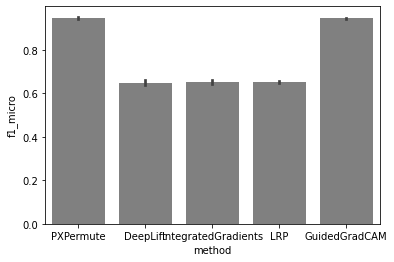

In [21]:
import seaborn as sns
sns.barplot(data = results_with_best_channels, 
            x = "method", 
            y = "f1_micro",
           palette = ["gray"])

In [22]:
results_with_best_channels.to_csv("results_with_best_channels.csv", index = True)